# Part 1: Linear First Order Wave Equation

Considering the PDE

$${\partial u \over \partial t} = -a{\partial u \over \partial x}$$

With Initial Conditions:
- $u(0 \le x < 50, 0) = 0$
- $u(50 \le x < 110, 0) = 100 \sin{\left(\pi\left(\frac{x-50}{60}\right)\right)}$
- $u(110 \le x \le 300, 0) = 0$

Boundary Conditions:
- $u(0, t) = 0$
- $u(300, t) = 0$

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display
from ipywidgets import interactive, fixed, IntSlider, FloatSlider, HBox, Layout # import widgets to generate interactive slider/plots
import warnings
warnings.filterwarnings('ignore')

## Task
Investigate the effect of varying the Courant number on the linear wave qquation for each
of these methods. Do this by keeping ∆x = 5 and changing the time step values, ∆t. It is up
to you to decide the best way to present the results of your investigation, using static plots,
animations and/or interactive plots.

Analyse the stability and accuracy of the methods.


## Solutions

### First upwind differencing method (explicit)

Uses a forward time backward space approximation: 

$$\frac{u_i^{n+1} - u_i^n}{\Delta t} = -a\frac{u_i^n - u_{i-1}^n}{\Delta x}$$

Rearranged:

$$u_i^{n+1} = u_i^n - c(u_i^n - u_{i-1}^n)$$

where $c = \frac{a \Delta t}{\Delta x}$.

In [2]:
def FUDM(dt, time):
    ### /// SOLVING THE PROBLEM ///
    # parameters
    a = 300 # FIX
    dx = 5 # FIX
    L = 300 # FIX
    nx = int(L/dx) # FIX
    T = 0.01666 * 40 # FIX
    
    nt = int(T / dt)
    x = np.linspace(0, 300, nx + 1)
    t = np.linspace(0, T, nt + 1)
    c = a*dt / dx
    
    # initial and boundary conditions
    uIC = np.zeros(nx + 1)
    xdom = np.where((50 <= x)  & (x < 110))
    uIC[xdom] = 100 * np.sin(np.pi * (x[xdom] - 50)/ 60)

    uB1 = uB2 = 0 # already taken into account

    # Set up solution matrix 
    uSOL = np.zeros((nx+1, nt+1))
    uSOL[:,0] = uIC

    for n in range(1, nt+1): 
        uSOL[1:-1, n] = uSOL[1:-1, n-1] - c*(uSOL[1:-1, n-1] - uSOL[0:-2, n-1])
    
    ### /// Animation ///
    # plot of analytic solution
    x_a = np.linspace(-L, L, 2*nx + 1)
    uIC_a = np.zeros(2*nx + 1)
    xdom_a = np.where((50 <= x_a)  & (x_a < 110))
    uIC_a[xdom_a] = 100 * np.sin(np.pi * (x_a[xdom_a] - 50)/ 60)

    
    plt.figure()
    plt.plot(x_a + a*time, uIC_a, color='red', linestyle='dashed', label='Analytic solution')

    
    # time index
    ind = round(time/dt)
        
    # plot for given dt at given time
    plt.plot(x, uSOL[:,ind], label='Numerical solution')
    plt.title(f'Upwind Method Numerical Results for $\\Delta t$ = {dt}')
    plt.xlabel('x')
    plt.xlim(0, 300)
    plt.ylabel('u')
    plt.ylim(-30, 150)
    
    plt.text(20, 120, f't = {time:.2f}')
    plt.text(20, 130, f'Courant number = {c:.4f}')
    
    plt.legend(loc='upper right')
    

In [3]:
# interactive plot
dt_slider = FloatSlider(min=0.00001, max=0.05, step=0.00001, value = 0.01666)
t_slider = FloatSlider(min=0, max=0.01666*40, step=0.01666)

def slider_change(change):
    t_slider.step = dt_slider.value
    
dt_slider.observe(slider_change, 'value')

IP1 = interactive(FUDM, dt=dt_slider, time = t_slider)
print('Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.')
IP1

Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.


interactive(children=(FloatSlider(value=0.01666, description='dt', max=0.05, min=1e-05, step=1e-05), FloatSlid…

### Euler BTCS method (implicit)

Uses a backward time central space approximation:

$$\frac{u_i^{n+1} - u_i^n}{\Delta t} = -a\frac{u_{i+1}^{n+1} - u_{i-1}^{n+1}}{2 \Delta x}$$

Rearranged:

$$\frac{1}{2}cu_{i-1}^{n+1} - u_{i}^{n+1} - \frac{1}{2}cu_{i+1}^{n+1} = -u_i^n$$

where $c = \frac{a\Delta t}{\Delta x}$. This creates a tridiagonal system of equeations.

In [4]:
def BTCS(dt, time):
    # parameters
    # parameters
    a = 300 # FIX
    dx = 5 # FIX
    L = 300 # FIX
    nx = int(L/dx) # FIX
    T = 0.01666 * 40 # FIX
    
    nt = int(T/dt)
    x = np.linspace(0, L, nx + 1)
    t = np.linspace(0, T, nt + 1)
    c = a*dt / dx
    
    # initial and boundary conditions
    uIC = np.zeros(nx + 1)
    xdom = np.where((50 <= x)  & (x < 110))
    uIC[xdom] = 100 * np.sin(np.pi * (x[xdom] - 50)/ 60)

    uB1 = uB2 = 0 # already taken into account
    
    # Set up solution matrix 
    uSOL = np.zeros((nx+1, nt+1))
    uSOL[:,0] = uIC

    # Tridiagonal matrix
    ld = - 1/2 * c * np.ones(nx-2)
    d = np.ones(nx-1)
    ud = 1/2 * c * np.ones(nx-2)

    A = np.diag(ld, -1) + np.diag(d, 0) + np.diag(ud, 1)

    for n in range(1, nt+1):
        # constant vector
        d = uSOL[1:-1, n-1]
        
        # solution at time n
        uSOL[1:-1, n] = np.linalg.solve(A, d)
    
    
    ### /// Animation ///
    # plot of analytic solution
    x_a = np.linspace(-L, L, 2*nx + 1)
    uIC_a = np.zeros(2*nx + 1)
    xdom_a = np.where((50 <= x_a)  & (x_a < 110))
    uIC_a[xdom_a] = 100 * np.sin(np.pi * (x_a[xdom_a] - 50)/ 60)

    plt.figure()
    plt.plot(x_a + a*time, uIC_a, color='red', linestyle='dashed', label='Analytic solution')
    
    # time index
    ind = round(time/dt)
        
    # plot for given dt at given time
    plt.plot(x, uSOL[:,ind], label='Numerical solution')
    plt.title(f'Euler BTCS Method Numerical Results for $\\Delta t$ = {dt}')
    plt.xlabel('x')
    plt.xlim(0, 300)
    plt.ylabel('u')
    plt.ylim(-30, 150)
    
    plt.text(20, 120, f't = {time:.2f}')
    plt.text(20, 130, f'Courant number = {c:.4f}')
    
    plt.legend(loc='upper right')


In [5]:
# interactive plot
dt_slider = FloatSlider(min=0.00001, max=0.05, step=0.00001, value = 0.01666)
t_slider = FloatSlider(min=0, max=0.01666*40, step=0.01666)

def slider_change(change):
    t_slider.step = dt_slider.value
    
dt_slider.observe(slider_change, 'value')

IP2 = interactive(BTCS, dt=dt_slider, time = t_slider)
print('Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.')
IP2

Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.


interactive(children=(FloatSlider(value=0.01666, description='dt', max=0.05, min=1e-05, step=1e-05), FloatSlid…

### Lax-Wendroff method (multi-step)

Applies Lax's method (FTCS replacing $u_i^n = \frac{1}{2}(u_{i-1}^{n} + u_{i+1}^{n})$) to calculate the solution at intermediate grid point in both space and time $(i + \frac{1}{2}, n + \frac{1}{2})$. Resulting in:

$$u_{i+\frac{1}{2}}^{n + \frac{1}{2}} = \frac{1}{2}(u_i^n + u_{i+1}^{n}) - \frac{c}{2}(u_{i+1}^{n} - u_i^n)$$

and

$$u_{i-\frac{1}{2}}^{n + \frac{1}{2}} = \frac{1}{2}(u_{i-1}^n + u_{i}^{n}) - \frac{c}{2}(u_{i}^{n} - u_{i-1}^n)$$

The final step $(i, n+1)$ is then calculated using the Leapfrog method (CTCS about intermediate point with half steps), substituting in the intermediate step solutions:

$$u_i^{n+1} = u_i^n - c (u_{i + \frac{1}{2}}^{n + \frac{1}{2}} - u_{i-\frac{1}{2}}^{n+\frac{1}{2}})$$

where $c = \frac{a\Delta t}{\Delta x}$.


In [6]:
def LWM(dt, time):
    # parameters
    # parameters
    a = 300 # FIX
    dx = 5 # FIX
    L = 300 # FIX
    nx = int(L/dx) # FIX
    T = 0.01666 * 40 # FIX
    
    nt = int(T/dt)
    x = np.linspace(0, L, nx + 1)
    t = np.linspace(0, T, nt + 1)
    c = a*dt / dx
    
    # initial and boundary conditions
    uIC = np.zeros(nx + 1)
    xdom = np.where((50 <= x)  & (x < 110))
    uIC[xdom] = 100 * np.sin(np.pi * (x[xdom] - 50)/ 60)

    uB1 = uB2 = 0 # already taken into account
    
    # Set up solution matrix 
    uSOL = np.zeros((nx+1, nt+1))
    uSOL[:,0] = uIC
    
    # Calculating solution
    for n in range(1, nt+1):
        # intermediate steps
        u_phs = 1/2 * (uSOL[1:-1, n-1] + uSOL[2:, n-1]) - c/2 * (uSOL[2:, n-1] - uSOL[1:-1, n-1])
        u_nhs = 1/2 * (uSOL[0:-2, n-1] + uSOL[1:-1, n-1]) - c/2 * (uSOL[1:-1, n-1] - uSOL[0:-2, n-1])
    
        # whole step
        uSOL[1:-1, n] = uSOL[1:-1, n-1] - c * (u_phs - u_nhs)

    ### /// Animation ///
    # plot of analytic solution
    x_a = np.linspace(-L, L, 2*nx + 1)
    uIC_a = np.zeros(2*nx + 1)
    xdom_a = np.where((50 <= x_a)  & (x_a < 110))
    uIC_a[xdom_a] = 100 * np.sin(np.pi * (x_a[xdom_a] - 50)/ 60)

    plt.figure()
    plt.plot(x_a + a*time, uIC_a, color='red', linestyle='dashed', label='Analytic solution')
    
    # time index
    ind = round(time/dt)
        
    # plot for given dt at given time
    plt.plot(x, uSOL[:,ind], label='Numerical solution')
    plt.title(f'Lax-Wendroff Method Numerical Results for $\\Delta t$ = {dt}')
    plt.xlabel('x')
    plt.xlim(0, 300)
    plt.ylabel('u')
    plt.ylim(-30, 150)
    
    plt.text(20, 120, f't = {time:.2f}')
    plt.text(20, 130, f'Courant number = {c:.4f}')
    
    plt.legend(loc='upper right')

In [7]:
# interactive plot
dt_slider = FloatSlider(min=0.00001, max=0.05, step=0.00001, value = 0.01666)
t_slider = FloatSlider(min=0, max=0.01666*40, step=0.01666)

def slider_change(change):
    t_slider.step = dt_slider.value
    
dt_slider.observe(slider_change, 'value')

IP3 = interactive(LWM, dt=dt_slider, time = t_slider)
print('Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.')
IP3

Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.


interactive(children=(FloatSlider(value=0.01666, description='dt', max=0.05, min=1e-05, step=1e-05), FloatSlid…

# Part 2: Inviscid Burgers' Equation

Considering the PDE:

$${\partial u \over \partial t} = -u{\partial u \over \partial x}$$

In Conservative Form:

$${\partial u \over \partial t} = -{\partial \frac{u^2}{2} \over \partial x} = -{\partial E \over \partial x}$$

With Initial Conditions:
- $u(0 \le x < 2, 0) = 1$
- $u(2 \le x \le 4, 0) = 0$

Boundary Conditions:
- $u(0, t) = 1$
- $u(4, t) = 0$

## Task
Use the Lax and MacCormack methods to investigate this non-linear PDE. Investigate the
effect of varying the time step ∆t on the inviscid Burgers’ equation for each of these methods.
Do this by keeping ∆x = 0.1 and changing the time step values, ∆t. It is up to you to decide
the best way to present the results of your investigation, using static plots, animations and/or
interactive plots.

Analyse the stability and accuracy of the methods.


## Characteristics

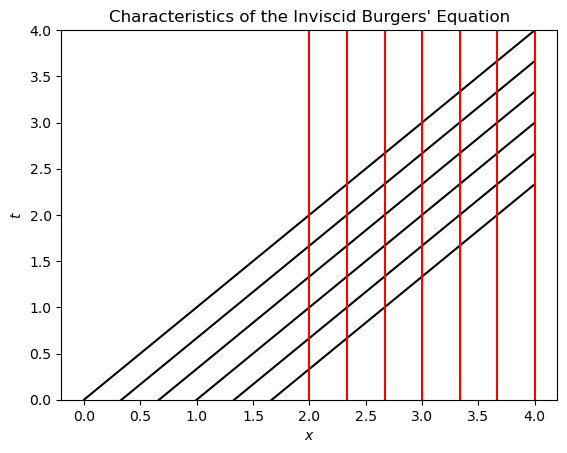

In [8]:
x = np.linspace(0, 4, 1000)

# Initial conditions function
def F(x):
    if 0 <= x <2:
        return 1
    if 2 <= x <=4:
        return 0

def t(x, xi):
    return (x - xi) / F(xi)

    
xi_1 = np.linspace(0, 2, 7)
xi_2 = np.linspace(2, 4, 7)

plt.figure()
for i in range(len(xi_1)):
    plt.plot(x, t(x, xi_1[i]), color='black')
for j in range(len(xi_2)):
    plt.axvline(x = xi_2[j], color='red')
    
plt.ylim(0, 4)
plt.xlabel('$x$')
plt.ylabel('$t$')
plt.title("Characteristics of the Inviscid Burgers' Equation")
plt.show()

## Solutions

### Lax method
FTCS approximation taking $u_i^n = \frac{1}{2}(u_{i-1}^{n} + u_{i+1}^{n})$. Thus,


$$u_i^{n+1} = \frac{1}{2}(u_{i-1}^{n} + u_{i+1}^{n}) - \frac{\Delta t}{4 \Delta x}\left[(u_{i+1}^n)^2 - (u_{i-1}^n)^2\right]$$

In [9]:
def LM(dt, time):
    # parameters
    dx = 0.1 # FIX
    L = 4 # FIX
    nx = int(L/dx) # FIX
    T = 4 # FIX
    
    nt = int(T/dt)
    x = np.linspace(0, L, nx + 1)
    t = np.linspace(0, T, nt + 1)

    # initial and boundary conditions
    uIC = np.zeros(nx + 1)
    xdom = np.where((0 <= x)  & (x < 2))
    uIC[xdom] = 1

    uB1 = 1
    uB2 = 0 # already taken into account

    uIC[0] = 1
    uIC
    
    # Set up solution matrix 
    uSOL = np.zeros((nx+1, nt+1))
    uSOL[:,0] = uIC
    uSOL[0,:] = uB1
    uSOL[-1,:] = uB2
    
    # Solve
    for n in range(1, nt+1):
        # uSOL[1:-1, n] = 1/2 * (uSOL[0:-2, n-1] + uSOL[2:, n-1]) - (1/2 * (uSOL[0:-2, n-1] + uSOL[2:, n-1]) * dt) / (2*dx) * (uSOL[2:, n-1] - uSOL[0:-2, n-1])
        uSOL[1:-1, n] = 1/2 * (uSOL[0:-2, n-1] + uSOL[2:, n-1]) - dt / (4*dx) * (np.power(uSOL[2:, n-1], 2) - np.power(uSOL[0:-2, n-1], 2))
    
    ### /// Animation ///
    # plot of analytic solution
    x_a = np.linspace(-L, L, 2*nx + 1)
    uIC_a = np.zeros(2*nx + 1)
    xdom_a = np.where((-L <= x_a)  & (x_a < 2))
    uIC_a[xdom_a] = 1

    plt.figure()
    plt.plot(x_a + (1/2)*time, uIC_a, color='red', linestyle='dashed', label='Analytic solution')
    
    # time index
    ind = round(time/dt)
        
    # plot for given dt at given time
    plt.plot(x, uSOL[:,ind], label='Numerical solution')
    plt.title(f'Lax Method Numerical Results for $\\Delta t$ = {dt}')
    plt.xlabel('x')
    plt.xlim(0, 4)
    plt.ylabel('u')
    plt.ylim(-1, 3)
    
    plt.text(0.2, 2.5, f't = {time:.2f}')
    
    plt.legend(loc='upper right')

In [10]:
# interactive plot
dt_slider = FloatSlider(min=0.01, max=0.2, step=0.01, value = 0.1)
t_slider = FloatSlider(min=0, max=4, step=0.1)

def slider_change(change):
    t_slider.step = dt_slider.value
    
dt_slider.observe(slider_change, 'value')

IP4 = interactive(LM, dt=dt_slider, time = t_slider)
print('Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.')
IP4

Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.


interactive(children=(FloatSlider(value=0.1, description='dt', max=0.2, min=0.01, step=0.01), FloatSlider(valu…

### MacCormack method

Uses a combination of forward and backward differencing with an intermediate step, in addition to averaging, as follows:

Intermediate step via forward differencing in space:
$$\frac{u_{i}^{*} - u_i^n}{\Delta t} = - \frac{E_{i+1}^{n} - E_{i}^{n}}{\Delta x}$$

such that 

$$u_{i}^{*} = u_i^n - \frac{\Delta t}{\Delta x}(E_{i+1}^{n} - E_i^n) = u_i^n - \frac{\Delta t}{2\Delta x}((u_{i+1}^{n})^2 - (u_i^n)^2)$$

Final step via backward differencing in space:
$$\frac{u_i^{n+1} - u_{i}^{n + \frac{1}{2}}}{\frac{1}{2}\Delta t} = - \frac{E_i^* - E_{i-1}^{*}}{\Delta x}$$

with $u_i^{n + \frac{1}{2}} = \frac{1}{2}(u_i^n + u_i^*)$ and substituting the calculated intermediate steps $(*)$ such that

$$u_i^{n+1} = \frac{1}{2}\left[(u_i^n + u_i^*) - \frac{\Delta t}{\Delta x}(E_i^* - E_{i-1}^*)\right] = \frac{1}{2}\left[(u_i^n + u_i^*) - \frac{\Delta t}{2 \Delta x}((u_i^*)^2 - (u_{i-1}^*)^2)\right]$$

In [11]:
def MCM(dt, time): 
    # parameters
    dx = 0.1 # FIX
    L = 4 # FIX
    nx = int(L/dx) # FIX
    T = 4 # FIX
    
    nt = int(T/dt)
    x = np.linspace(0, L, nx + 1)
    t = np.linspace(0, T, nt + 1)

    # initial and boundary conditions
    uIC = np.zeros(nx + 1)
    xdom = np.where((0 <= x)  & (x < 2))
    uIC[xdom] = 1

    uB1 = 1
    uB2 = 0 # already taken into account

    uIC[0] = 1
    uIC
    
    # Set up solution matrix 
    uSOL = np.zeros((nx+1, nt+1))
    uSOL[:,0] = uIC
    uSOL[0,:] = uB1
    uSOL[-1,:] = uB2
    
    # Solve
    for n in range(1, nt+1):
        # intermediate steps
        u_s = uSOL[1:-1, n-1] - dt / (2*dx) * (np.power(uSOL[2:, n-1], 2) - np.power(uSOL[1:-1, n-1], 2))
        u_sm1 = uSOL[0:-2, n-1] - dt / (2*dx) * (np.power(uSOL[1:-1, n-1], 2) - np.power(uSOL[0:-2, n-1], 2))
    
        # whole step
        uSOL[1:-1, n] = 1/2 * ((uSOL[1:-1, n-1] + u_s) - dt / (2*dx) * (np.power(u_s, 2) - np.power(u_sm1, 2)))
    
    ### /// Animation ///
    # plot of analytic solution
    x_a = np.linspace(-L, L, 2*nx + 1)
    uIC_a = np.zeros(2*nx + 1)
    xdom_a = np.where((-L <= x_a)  & (x_a < 2))
    uIC_a[xdom_a] = 1

    plt.figure()
    plt.plot(x_a + (1/2)*time, uIC_a, color='red', linestyle='dashed', label='Analytic solution')
    
    # time index
    ind = round(time/dt)
        
    # plot for given dt at given time
    plt.plot(x, uSOL[:,ind], label='Numerical solution')
    plt.title(f'MacCormack Method Numerical Results for $\\Delta t$ = {dt}')
    plt.xlabel('x')
    plt.xlim(0, 4)
    plt.ylabel('u')
    plt.ylim(-1, 3)
    
    plt.text(0.2, 2.5, f't = {time:.2f}')
    
    plt.legend(loc='upper right')

In [12]:
dt_slider = FloatSlider(min=0.01, max=0.2, step=0.01, value = 0.1)
t_slider = FloatSlider(min=0, max=4, step=0.1)

def slider_change(change):
    t_slider.step = dt_slider.value
    
dt_slider.observe(slider_change, 'value')

IP5 = interactive(MCM, dt=dt_slider, time = t_slider)
print('Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.')
IP5

Arbitrarily adjust time step and the time under consideration via the sliders below. Note that the time slider cannot be at the final time value when adjusting the time step. Specific values can be chosen by clicking on the numbers.


interactive(children=(FloatSlider(value=0.1, description='dt', max=0.2, min=0.01, step=0.01), FloatSlider(valu…